In [34]:
import time
import concurrent.futures
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from order_of_convergence import order_of_convergence

In [37]:
class DiscreteOrdinates:
    def __init__(
        self,
        angles,
        weights,
        left_boundary,
        right_boundary,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=0,
        title_start="",
        x_start=0,
        x_end=1,
        n_surfaces=10,
    ):

        self.angles = angles
        self.weights = weights

        assert (
            isinstance(left_boundary, (int, float)) or left_boundary == "reflecting"
        ), "left_boundary must be a float or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            isinstance(right_boundary, (int, float)) or right_boundary == "reflecting"
        ), "right_boundary must be a float or 'reflecting'"
        self.right_boundary = right_boundary

        self.volumetric_source = volumetric_source
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.title_start = title_start
        self.x_start = x_start
        self.x_end = x_end
        self.n_surfaces = n_surfaces

        self.n_cells = n_surfaces - 1

        assert x_start < x_end, "x_start must be less than x_end"

        assert np.all(np.array(angles) != 0), "angles must not be zero"

        self.surface_x_pos = np.linspace(x_start, x_end, n_surfaces)

        self.delta_x = self.surface_x_pos[1] - self.surface_x_pos[0]

        self.cell_x_pos = np.linspace(
            x_start + self.delta_x / 2, x_end - self.delta_x / 2, self.n_cells
        )

        self.angular_fluxes_at_surfaces = np.zeros((n_surfaces, len(angles)))

        self.average_scalar_flux_at_cells = np.zeros(self.n_cells)

    def angular_flux(self, max_iter=20000, tol=1e-10):

        angular_flux_matrix_objs = {
            angle: AngularFluxMatrix(self, angle) for angle in self.angles
        }
        zero_block = np.zeros((self.n_surfaces, self.n_surfaces))
        number_of_angles = len(self.angles)

        block_matrix_components = (
            []
        )  # this will be a list of lists, where outer list components are rows
        for block_index, angle in enumerate(self.angles):
            submatrix = angular_flux_matrix_objs[angle].A_mat
            row = (
                block_index * [zero_block]
                + [submatrix]
                + (number_of_angles - block_index - 1) * [zero_block]
            )
            block_matrix_components.append(row)

        block_matrix = sp.sparse.bmat(block_matrix_components, format="csc")

        # apply neumman boundary condition to boundary
        # this could be better, but homework...
        if self.left_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_pos_angle * self.n_surfaces, nth_neg_angle * self.n_surfaces
                    ] = -1

        if self.right_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_neg_angle * self.n_surfaces + self.n_surfaces - 1,
                        nth_pos_angle * self.n_surfaces + self.n_surfaces - 1,
                    ] = -1

        if __debug__:
            full = block_matrix.toarray()

        start_time = time.time()
        for iter in range(100):

            # scalar flux at each node

            old_scalar_flux = self.average_scalar_flux_at_cells.copy()

            # generate the b vector based on the old scalar flux
            b_vec = np.concatenate(
                [
                    angular_flux_matrix_objs[angle].b_vec(
                        self.volumetric_source, old_scalar_flux
                    )
                    for angle in self.angles
                ]
            )

            angular_flux_long = sp.sparse.linalg.spsolve(block_matrix, b_vec)

            # list where each element is a list of angular fluxes for each angle
            # the same order as self.angles
            self.angular_fluxes_at_surfaces = np.split(
                angular_flux_long, number_of_angles
            )

            self.angular_fluxes_at_cells = [
                angular_flux_matrix_objs[angle].average_angular_flux(
                    self.angular_fluxes_at_surfaces[i]
                )
                for i, angle in enumerate(self.angles)
            ]

            self.average_scalar_flux_at_cells = sum(
                angular_flux_at_angle * weight
                for angular_flux_at_angle, weight in zip(
                    self.angular_fluxes_at_cells, self.weights
                )
            )

            if np.allclose(
                old_scalar_flux, self.average_scalar_flux_at_cells, atol=tol
            ):
                print(f"{self.title_start}: Converged after {iter} iterations")
                end_time = time.time()
                self.solver_time = end_time - start_time
                break

            if iter == max_iter - 1:
                end_time = time.time()
                self.solver_time = end_time - start_time
                print(f"{self.title_start}: Did not converge after {iter} iterations")

        return self.average_scalar_flux_at_cells

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(
            self.cell_x_pos,
            self.average_scalar_flux_at_cells,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_surfaces):
            ax.scatter(
                self.surface_x_pos,
                angular_fluxes,
                label=rf"$\psi$ surf $\mu=${angle:.2f}",
                marker="x",
            )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_cells):
            ax.scatter(
                self.cell_x_pos,
                angular_fluxes,
                label=rf"$\langle \psi \rangle$ cell at $\mu=${angle:.2f}",
                marker="o",
            )

        # ax.set_ylabel(r"$\langle \phi \rangle$")
        ax.set_xlabel("x")
        ax.legend()
        ax.set_title(self.title_start)

        return fig, ax

    def angular_flux_at_xloc(self, xloc):
        # find nearest cell
        cell_index = np.argmin(np.abs(self.cell_x_pos - xloc))

        angular_flux_per_angle = np.array(
            [angular_flux[cell_index] for angular_flux in self.angular_fluxes_at_cells]
        )

        return self.angles, angular_flux_per_angle

    def current(self):
        scalar_flux_derivative = np.gradient(
            self.average_scalar_flux_at_cells, self.cell_x_pos
        )
        transport_xs = self.sigma_t - 0  # since Sigma_s1 = 0
        diffusion_coeff = 1 / 3 / transport_xs
        current = -diffusion_coeff * scalar_flux_derivative
        return self.cell_x_pos, current

    def angular_moments(self, number_of_moments=8):
        legendre_polynomials = [
            sp.special.legendre(i) for i in range(number_of_moments)
        ]

        angular_flux_moments = {}

        for moment_p in range(number_of_moments):
            legendre_polynomial = sp.special.legendre(moment_p)
            angular_flux_moments[moment_p] = sum([
                weight_m * legendre_polynomial(mu_m) * angular_flux_at_cell
                for weight_m, mu_m, angular_flux_at_cell in zip(
                    self.weights, self.angles, self.angular_fluxes_at_cells
                )
            ])
            
        # reconstruct the angular fluxes from the moments
        angular_fluxes_reconstructed = {}
        for angle in self.angles:
            angular_fluxes_reconstructed[angle] = sum([
                angular_flux_moments[moment_p] * legendre_polynomials[moment_p](angle) * (2 * moment_p + 1) / 2
                for moment_p in range(number_of_moments)
            ])
            
        return angular_flux_moments, angular_fluxes_reconstructed
    
    def angular_moments_plot(self):
        angular_flux_moments, angular_fluxes_reconstructed = self.angular_moments()
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        for moment_p, angular_flux_moment in angular_flux_moments.items():
            ax[0].plot(self.cell_x_pos, angular_flux_moment, label=f"P{moment_p}")
            
        ax[0].set_title("Angular Flux Moments")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel(r"$\phi^p$")
        ax[0].legend()
        
        for angle, angular_flux in angular_fluxes_reconstructed.items():
            ax[1].plot(self.cell_x_pos, angular_flux, label=f"{angle:.2f}")
            
        ax[1].set_title("Reconstructed Angular Fluxes")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel(r"$\psi(\mu)$")
        ax[1].legend(title=r"$\mu$")
        
        reconstructed_scalar_flux = sum([
            angular_flux * weight
            for angular_flux, weight in zip(angular_fluxes_reconstructed.values(), self.weights)
        ])
        
        ax[2].plot(self.cell_x_pos, self.average_scalar_flux_at_cells, label="Original")
        ax[2].scatter(self.cell_x_pos, reconstructed_scalar_flux, label="Reconstructed")
        ax[2].set_title("Scalar Flux")
        ax[2].set_xlabel("x")
        ax[2].legend()
        
        # add text in the center above the plots
        fig.text(0.5, 0.95, self.title_start, ha='center', va='center')
        
        return fig, ax

class AngularFluxMatrix:
    def __init__(self, discrete_ordinates: DiscreteOrdinates, mu):
        self.mu = mu
        self.discrete_ordinates: DiscreteOrdinates = discrete_ordinates

        self.sign_of_direction = np.sign(mu)
        self.surface_angular_flux = np.zeros(self.discrete_ordinates.n_surfaces)
        self.cell_averaged_angular_flux = np.zeros(self.discrete_ordinates.n_cells)

        self.tau_coeff = (
            self.discrete_ordinates.sigma_t
            * self.sign_of_direction
            * self.discrete_ordinates.delta_x
            / self.mu
        )
        self.exp_term = np.exp(-self.tau_coeff)

        self.diag_index = int(-1 * self.sign_of_direction)

        self.A_mat = sp.sparse.diags(
            [1, -self.exp_term],
            [0, self.diag_index],
            shape=(
                self.discrete_ordinates.n_surfaces,
                self.discrete_ordinates.n_surfaces,
            ),
            format="lil",
        )

    def b_vec(self, cell_source, scalar_flux_at_cells):
        # self.source_at_cell = [
        #     (cell_source + scalar_flux * self.discrete_ordinates.sigma_s) / 2
        #     for scalar_flux in scalar_flux_at_cell
        # ]
        # self.decay_coeff = 1 / (self.discrete_ordinates.sigma_t) * (1 - self.exp_term)
        # source_at_cell_with_decay = [
        #     source * self.decay_coeff for source in self.source_at_cell
        # ]
        fixed_source = np.ones(self.discrete_ordinates.n_cells) * cell_source * (1 - self.exp_term) / 2

        source = [
            fixed_source_i / self.discrete_ordinates.sigma_t  / 2
            + (
                scalar_flux_at_cell
                * (1 - self.exp_term)
                * self.discrete_ordinates.sigma_s
                / (2 * self.discrete_ordinates.sigma_t)
            )
            for fixed_source_i, scalar_flux_at_cell in zip(
                fixed_source, scalar_flux_at_cells
            )
        ]

        if self.sign_of_direction > 0:
            if isinstance(self.discrete_ordinates.left_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.left_boundary
                # I am being lazy with the vacuum boundary condition
                # (not using the extrapolation distance)
            else:
                psi_initial = 0
            return [psi_initial] + source

        elif self.sign_of_direction < 0:
            if isinstance(self.discrete_ordinates.right_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.right_boundary
            else:
                psi_initial = 0
            return source + [psi_initial]

        else:
            raise ValueError("Direction must be positive or negative")

    def average_angular_flux(self, angular_flux_surface):
        # this is really bad code design (dependent on self.source_at_cell/decay_coeff)
        # , but the source at the cell was set up
        # when the b vector was generated...
        # That is, b_vec must have already been run

        # A_coeff = lambda i : self.source_at_cell[i] / self.discrete_ordinates.sigma_t
        sigma_s = self.discrete_ordinates.sigma_s
        volumetric_source = self.discrete_ordinates.volumetric_source
        old_scalar_flux = self.discrete_ordinates.average_scalar_flux_at_cells
        A_coeff = (
            lambda i: (sigma_s * old_scalar_flux[i]  + volumetric_source) / self.discrete_ordinates.sigma_t / 2
        )
        B_coeff = -self.mu / (
            self.discrete_ordinates.sigma_t * 
            self.discrete_ordinates.delta_x) # I thought it was delta x instead of 1, but these answers make more sense

        angular_flux_cell_average = np.zeros(self.discrete_ordinates.n_cells)

        if self.sign_of_direction > 0:
            for i in range(self.discrete_ordinates.n_cells):
                flux_exit = angular_flux_surface[i+1]
                flux_incident = angular_flux_surface[i]

                angular_flux_cell_average[i] = A_coeff(i) + B_coeff * (
                    flux_exit - flux_incident
                )
        elif self.sign_of_direction < 0:
            for i in range(self.discrete_ordinates.n_cells):
                flux_exit = angular_flux_surface[i]
                flux_incident = angular_flux_surface[i + 1]

                angular_flux_cell_average[i] = A_coeff(i) + -B_coeff * (
                    flux_exit - flux_incident
                )

        return angular_flux_cell_average


def test_convergence(
    problem, number_of_cells, name="a", sigma_s_over_sigma_t_ratios=[0, 0.01, 0.99, 1]
):
    sigma_t = 1
    orders_of_convergence = {}
    error_dict = {}

    for sigma_s_over_sigma_t in sigma_s_over_sigma_t_ratios:
        solutions = []

        for n_cells in number_of_cells[sigma_s_over_sigma_t]:
            sigma_s = sigma_s_over_sigma_t * sigma_t

            solution = problem(n_cells, sigma_s, sigma_t)
            solutions.append(solution)


        truth = solutions[-1]
        errors = []
        
        # scaled_solutions = [solution * np.average(truth)/np.average(solution) for solution in solutions]
        # solutions = scaled_solutions
        for solution in solutions[:-1]:
            step = int(len(truth) / len(solution))
            sliced_truth = truth[::step]
            error = np.linalg.norm(np.array(sliced_truth) - np.array(solution))
            errors.append(error)
        error_dict[sigma_s_over_sigma_t] = errors
        orders_of_convergence[sigma_s_over_sigma_t] = order_of_convergence(
            number_of_cells[sigma_s_over_sigma_t][:-1], errors
        )
        
    # for solution in solutions[:-1]:
        # print(np.average(solutions[-1]) / np.average(solution))
        

    fig_sol, ax_sol = plt.subplots()
    for solution in solutions:
        x_pos = np.linspace(0, 1, len(solution))
        ax_sol.plot(x_pos, solution, label="Solution")

    fig, ax = plt.subplots()

    for sigma_s_over_sigma_t, errors in error_dict.items():
        ax.plot(
            number_of_cells[sigma_s_over_sigma_t][:-1],
            errors,
            label=f"{sigma_s_over_sigma_t} ({orders_of_convergence[sigma_s_over_sigma_t]:.2f})",
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title=rf"$\frac{{\Sigma_s}}{{\Sigma_t}}$ (Conv. Order)")
    ax.set_xlabel("Number of Cells")
    ax.set_ylabel("Error")
    ax.set_title(f"2{name}) Sn (S16)")

    return fig_sol, ax_sol, fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 <Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '2a) Sn (S16)'}, xlabel='Number of Cells', ylabel='Error'>)

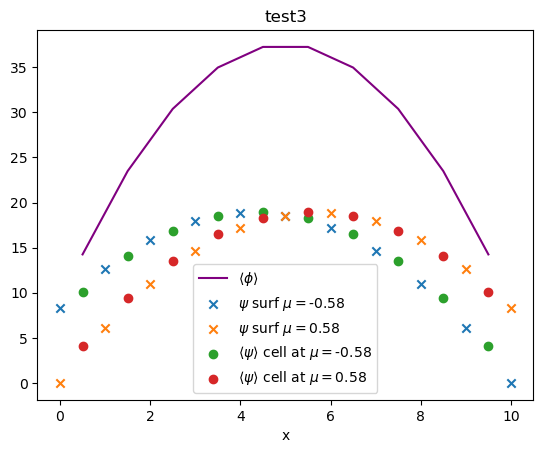

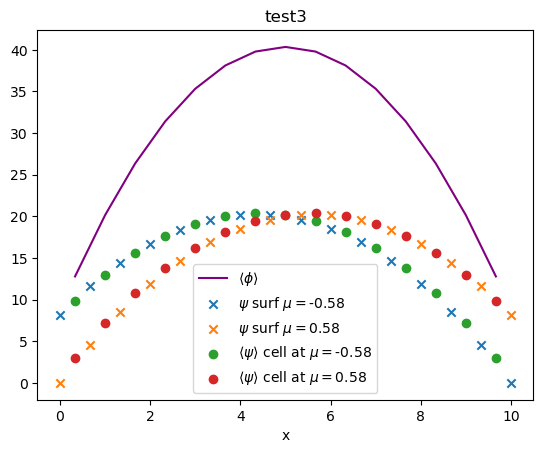

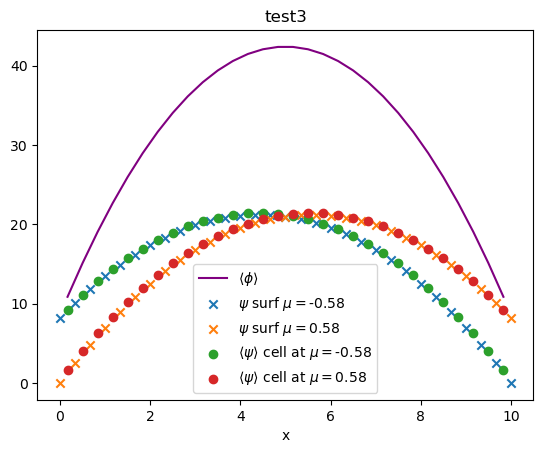

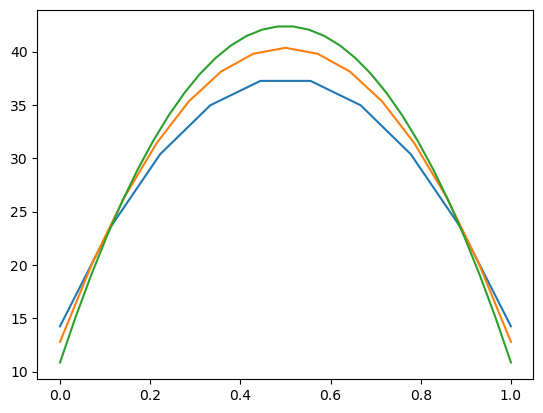

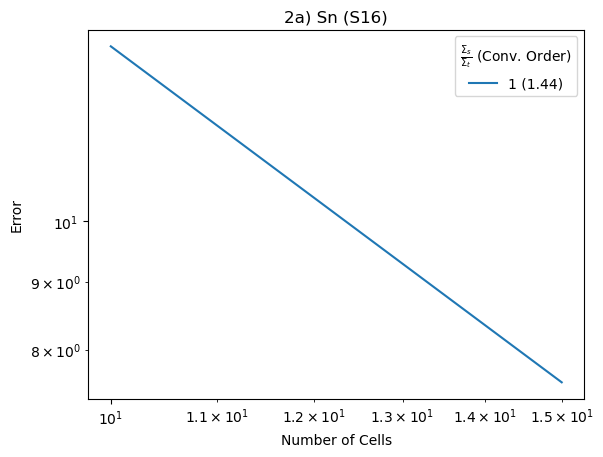

In [38]:
# Problem 3
n_cells = {1 : [10, 15, 30]}
number_of_directions = 2
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)

def problem(n_cells, sigma_s, sigma_t):
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary=0,
        right_boundary=0,
        volumetric_source=1,
        sigma_t=sigma_t,
        sigma_s=sigma_s,
        title_start="test3",
        x_end=10,
        n_surfaces=n_cells + 1
    )
    flux = solver.angular_flux()
    solver.plot()
    return flux

test_convergence(problem, n_cells, sigma_s_over_sigma_t_ratios=[1])